<a href="https://colab.research.google.com/github/AlirezaGhavidel70/training-and-testing-deploying-the-AI-decision-agents/blob/main/Random_Trajectory_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @author: Alireza Ghavidel
# This code shows a random trajectory realization for AI agent decisions and compare with condition-based (CB) policies

# upload external file before run (Trained_model.pth)
from google.colab import files
files.upload()


Saving Trained_model.pth to Trained_model.pth


{'Trained_model.pth': b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Y\x00\t\x00Memphis_PER_PDQN_30years_w1_5_w2_5_SemiRandom_FRGsystem_Map_Action_LHS_withoutDS/data.pklFB\x05\x00ZZZZZ\x80\x02ccollections\nOrderedDict\nq\x00)Rq\x01(X\r\x00\x00\x00layer1.weightq\x02ctorch._utils\n_rebuild_tensor_v2\nq\x03((X\x07\x00\x00\x00storageq\x04ctorch\nFloatStorage\nq\x05X\x01\x00\x00\x000q\x06X\x03\x00\x00\x00cpuq\x07K\xa8tq\x08QK\x00K\x18K\x07\x86q\tK\x07K\x01\x86q\n\x89h\x00)Rq\x0btq\x0cRq\rX\x0b\x00\x00\x00layer1.biasq\x0eh\x03((h\x04h\x05X\x01\x00\x00\x001q\x0fh\x07K\x18tq\x10QK\x00K\x18\x85q\x11K\x01\x85q\x12\x89h\x00)Rq\x13tq\x14Rq\x15X\r\x00\x00\x00layer2.weightq\x16h\x03((h\x04h\x05X\x01\x00\x00\x002q\x17h\x07M@\x02tq\x18QK\x00K\x18K\x18\x86q\x19K\x18K\x01\x86q\x1a\x89h\x00)Rq\x1btq\x1cRq\x1dX\x0b\x00\x00\x00layer2.biasq\x1eh\x03((h\x04h\x05X\x01\x00\x00\x003q\x1fh\x07K\x18tq QK\x00K\x18\x85q!K\x01\x85q"\x89h\x00)Rq#tq$Rq%X\r\x00\x00\x

In [ ]:
###############################################################################
############# User input values for testing/deployment the AI-agent ###########
###############################################################################

# Specify the life horizon of the bridge
life_span = 30
# contribution weights of indirect cost
w1=0.05
# Please specify the city: Mamphis (0) or San Francisco =1
#City = 0 # seismic region: 0: Memphis, 1: San Francisco, 2: other cities (you need to define the corresponding hazard curve)

# Specify the number of episodes to train the agent
num_test_episodes = int(1) # Since here only one realization should be shown, this value must be equal to 1

# Specify an individual bridge specifications that you want to test the trained agent ( it must be in the range of the trained model using LHS)
deck_area_test = 1009.02 # Bridge deck area, [square meter, m2]
L_d_test = 2 # Detour length, [kilometer]
ADT_test = 9540 # Average daily traffic, [vehicles per day]
r_Truck_test = 0.12 # Truck traffic ratio


## Hyperparameters and Utilities
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# LR is the learning rate of the ``Adam`` optimizer
BATCH_SIZE = 32
GAMMA = 0.96
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 5000
LR = 1e-2

###############################################################################
###############################################################################
###############################################################################

In [ ]:
# Code starts from here*-
"""
Fragility curves and risk analysis are incorporated in this code to find the earthquake damage state probabilities

@author: Alireza Ghavidel
"""
import numpy as np
import scipy
import sympy
from scipy import special
from sympy import *
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy import *
from scipy.stats import lognorm
from scipy.optimize import minimize, rosen, rosen_der
from scipy import special
from scipy.stats import norm

class FRAG_DRL:

    def __init__(self, time_t=[], jacket_time=[], extender_time=[], shearKey_time=[], RC_time=[], EB_time=[], city_hazard = 0):


        self.time_t=np.array(time_t)
        self.extender_time=np.array(extender_time)
        self.jacket_time= np.array(jacket_time)
        self.shearKey_time= np.array(shearKey_time)
        self.RC_time= np.array(RC_time)
        self.EB_time= np.array(EB_time)
        self.city_hazard = city_hazard


    def mod_frag(pf,x,mod_factors):

        f = lambda x,mu,sigma: scipy.stats.lognorm.cdf(x, sigma, loc=0, scale=np.exp(mu))
        x0 = np.asarray([np.log(1.5), 0.001])
        mu,sigma = scipy.optimize.curve_fit(f,x,pf,p0=x0,method='lm',maxfev=5000)[0]
        mu=np.log(np.exp(mu)*mod_factors[0])
        sigma=sigma*mod_factors[1]
        pf_mod = scipy.stats.lognorm.cdf(x, sigma, loc=0, scale=np.exp(mu))
        return pf_mod, mu,sigma


    def fraglity (self,):
        # To find the constant values, please refer to the paper "Padgett J E, Dennemann K and Ghosh J 2010 Risk-based seismic life-cycle cost–benefit
        #(LCC-B) analysis for bridge retrofit assessment Structural Safety 32 165–73 "
        frag_mod_factors_SJ= [1.03,1,1.16,1,1.17,1,1.20,1]
        frag_mod_factors_EB= [2.94,1,1.31,1,1.21,1,1.17,1]
        frag_mod_factors_RC= [1.04,1,0.96,1,1.01,1,1.05,1]
        frag_mod_factors_SE= [1.01,1,1.00,1,1.00,1,1.31,1]
        frag_mod_factors_SK= [1.01,1,0.98,1,0.99,1,1.01,1]
        frag_mod_factors_RC_SK= [1.04,1,0.96,1,1.04,1,1.12,1]
        frag_mod_factors_SE_SK= [1.01,1,0.97,1,0.99,1,1.37,1]
        frag_mod_factors_SJ_SE= [1.03,1,1.16,1,1.17,1,1.31,1]
        frag_mod_factors_SJ_SK= [1.03,1,1.16,1,1.17,1,1.37,1]
        frag_mod_factors_SJ_SE_SK=[1.03,1,1.16,1,1.17,1,1.37,1]



        PGA=np.linspace(np.log(0.01), np.log(3), 30)
        PGA=np.exp(PGA)
        size=PGA.size



        lam_factor_complete_sys= np.zeros(size)
        lam_factor_extensive_sys= np.zeros(size)
        lam_factor_moderate_sys= np.zeros(size)
        lam_factor_slight_sys= np.zeros(size)



        # To find the constant values, please refer to the paper "Padgett J E, Dennemann K and Ghosh J 2010 Risk-based seismic life-cycle cost–benefit
        #(LCC-B) analysis for bridge retrofit assessment Structural Safety 32 165–73 "
        P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21))/0.69)
        P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61))/0.60)
        P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86))/0.60)
        P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20))/0.61)





        x= Symbol('x')
        y2= 11.8246*sympy.exp(56.1606*((sympy.log(x/134.7200))**-1)) # it is for Memphis

        y2prime=y2.diff(x)
        yprime=y2prime
        f = lambdify(x, yprime, 'numpy')

        s=np.zeros(size)
        s1 = np.zeros(size)



        lam_factor_complete_sys= np.zeros(size)
        lam_factor_extensive_sys= np.zeros(size)
        lam_factor_moderate_sys= np.zeros(size)
        lam_factor_slight_sys= np.zeros(size)



        for sa in range (0,size):
            s[sa]=np.abs(f(PGA[sa]))
            if sa!=0:
                s1[sa]=s[sa]*np.abs((PGA[sa]-PGA[sa-1]))


        if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ_SE_SK[0]))/(0.69*frag_mod_factors_SJ_SE_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ_SE_SK[2]))/(0.60*frag_mod_factors_SJ_SE_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ_SE_SK[4]))/(0.60*frag_mod_factors_SJ_SE_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ_SE_SK[6]))/(0.61*frag_mod_factors_SJ_SE_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.extender_time and self.time_t>=self.jacket_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ_SE[0]))/(0.69*frag_mod_factors_SJ_SE[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ_SE[2]))/(0.60*frag_mod_factors_SJ_SE[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ_SE[4]))/(0.60*frag_mod_factors_SJ_SE[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ_SE[6]))/(0.61*frag_mod_factors_SJ_SE[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.shearKey_time and self.time_t>=self.jacket_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ_SK[0]))/(0.69*frag_mod_factors_SJ_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ_SK[2]))/(0.60*frag_mod_factors_SJ_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ_SK[4]))/(0.60*frag_mod_factors_SJ_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ_SK[6]))/(0.61*frag_mod_factors_SJ_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.extender_time and self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SE_SK[0]))/(0.69*frag_mod_factors_SE_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SE_SK[2]))/(0.60*frag_mod_factors_SE_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SE_SK[4]))/(0.60*frag_mod_factors_SE_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SE_SK[6]))/(0.61*frag_mod_factors_SE_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.RC_time and self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_RC_SK[0]))/(0.69*frag_mod_factors_RC_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_RC_SK[2]))/(0.60*frag_mod_factors_RC_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_RC_SK[4]))/(0.60*frag_mod_factors_RC_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_RC_SK[6]))/(0.61*frag_mod_factors_RC_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SK[0]))/(0.69*frag_mod_factors_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SK[2]))/(0.60*frag_mod_factors_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SK[4]))/(0.60*frag_mod_factors_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SK[6]))/(0.61*frag_mod_factors_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys


        elif self.time_t>=self.extender_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SE[0]))/(0.69*frag_mod_factors_SE[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SE[2]))/(0.60*frag_mod_factors_SE[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SE[4]))/(0.60*frag_mod_factors_SE[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SE[6]))/(0.61*frag_mod_factors_SE[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.RC_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_RC[0]))/(0.69*frag_mod_factors_RC[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_RC[2]))/(0.60*frag_mod_factors_RC[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_RC[4]))/(0.60*frag_mod_factors_RC[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_RC[6]))/(0.61*frag_mod_factors_RC[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys


        elif self.time_t>=self.EB_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_EB[0]))/(0.69*frag_mod_factors_EB[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_EB[2]))/(0.60*frag_mod_factors_EB[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_EB[4]))/(0.60*frag_mod_factors_EB[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_EB[6]))/(0.61*frag_mod_factors_EB[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.jacket_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ[0]))/(0.69*frag_mod_factors_SJ[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ[2]))/(0.60*frag_mod_factors_SJ[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ[4]))/(0.60*frag_mod_factors_SJ[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ[6]))/(0.61*frag_mod_factors_SJ[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys



        else:


            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys




        annual_rate_slight_sys=sum(lam_factor_slight_sys)
        annual_rate_moderate_sys=sum(lam_factor_moderate_sys)
        annual_rate_extensive_sys=sum(lam_factor_extensive_sys)
        annual_rate_complete_sys=sum(lam_factor_complete_sys)





        PT_slight_sys=1-np.exp(-annual_rate_slight_sys)
        PT_moderate_sys=1-np.exp(-annual_rate_moderate_sys)
        PT_extensive_sys=1-np.exp(-annual_rate_extensive_sys)
        PT_complete_sys=1-np.exp(-annual_rate_complete_sys)



        PP_sys=[1-(PT_slight_sys), -PT_moderate_sys+PT_slight_sys, -PT_extensive_sys+PT_moderate_sys,-PT_complete_sys+PT_extensive_sys, PT_complete_sys]

        P_sys = PP_sys

        return P_sys



In [ ]:
# -*- coding: utf-8 -*-
"""
Bridge Environment is developed here
@author: Alireza Ghavidel
"""

from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
from copy import deepcopy

class BridgeEnvFrg(Env):
    def __init__(self, life):

        # lets consider the order as following for components:
        # "0": Deck, "1":Super structure, "2": Sub structure,
        # Actions: we can take : Do nothing, Minor, Major and replacement
        self.action_space = Discrete(64) # 64: 4*4*4 actions //// 4 actions [do nothing, minor, major, replacement] for deck, superstructure and substructure
        # observation array
        self.observation_space = Box(low=np.array([0, 0, 0]), high=np.array([8,8,8]), shape = (3,), dtype=np.int64) # [Deck 0-8, Sperstructure 0-8, Substructure 0-8, seismic component 0-4]
        # Set start state
        self.state = np.zeros(shape=(3,),dtype = np.int64)
        self.state[0:3] =  np.random.randint(4,[9,9,9])    # initiating the initial state from the fair condition randomly
        self.total_steps = 0 # counting
        self.componenets = 3 # number of components
        self.life = life # life horizon
        self.city = 0 # city for risk analysis: 0: Memphis, 1: San Francisco
        self.damage = 0


    def step(self, action, Deck_area, L_d, ADT, r_Truck, jacketing = False, jacketing_t = 100, extender = False, extender_t = 100, shearKey = False, shearKey_t = 100, w1=0.05):
        # Markov transition matrices can be modified by the user if needed
        # condition-based rating
        state_old = deepcopy(self.state)
        trans = np.zeros(shape=[self.componenets,4,9,9])  # 3 comps, 4 actions, 9 states
        # Do nothing
        trans [0, 0] = [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0114, 0.9886, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0174, 0.9826, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0227, 0.9773, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0268, 0.9732, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0714, 0.9286, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0452, 0.1011, 0.8537]]

        trans [1, 0] = [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0282, 0.9718, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0107, 0.9893, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0147, 0.9853, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0194, 0.9806, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0246, 0.9754, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0276, 0.9724, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0532, 0.9468, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0282, 0.0995, 0.8723]]

        trans [2, 0] = [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0142, 0.9858, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0208, 0.9792, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0302, 0.9698, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0282, 0.9718, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0207, 0.9793, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0654, 0.9346, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0925, 0.8726]]


        # Minor maintenance
        trans [0:3, 1] = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.9, 0.1, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.80, 0.20, 0.0, 0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.4],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]

        # Major Maintenance
        trans [0:3, 2] = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.3, 0.4, 0.3, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.1, 0.3, 0.6, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.7, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.1, 0.85, 0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.9],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.02, 0.98],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]



        # Replace
        trans [0:3,3,:,8] = 1

        # unravel actions
        action_index = np.unravel_index(action,(4,4,4))  # (deck, superstructure, substructure, column, bearing, abutment, retrofitting combinations )
        action_index = np.asarray(action_index)

        # Damage State (DS) only reflect the DS happened in each year based on the seismic risk model. We don't propagate the DS to the next year
        self.damage = 0


        # Retrofitting configuration: we have 3 possible retrofitting actions: Seat extender, steel jacketing, and shear key
        if extender == True:
            self.extender_time = extender_t
        else:
            self.extender_time = []
        if jacketing == True:
            self.jacket_time = jacketing_t
        else:
            self.jacket_time = []
        if shearKey == True:
            self.shearKey_time = shearKey_t
        else:
            self.shearKey_time = []


        # here we call the fragility and risk analysis part to get the damage state probabilities
        FRG=FRAG_DRL(time_t=self.total_steps, jacket_time=self.jacket_time, extender_time=self.extender_time, shearKey_time=self.shearKey_time, RC_time=[], EB_time=[])
        P_sys=FRG.fraglity()



        # this part the next state is calculated based on the transition probabilities come from Markov matrices and fragility functions
        for component in range(self.componenets):
            self.state[component] = np.random.choice(9, p=trans[component][action_index[component]][self.state[component]])

        # Earthquake damage type
        self.damage = np.random.choice(5, p=P_sys)



        # Mapping DS to CR
        state_update = deepcopy(self.state)

        if self.damage == 0:
            self.state[0] = state_update[0]
            self.state[1] = state_update[1]
            self.state[2] = state_update[2]

        elif self.damage == 1:
            self.state[0] = np.min([state_update[0],6])
            self.state[1] = np.min([state_update[1],6])
            self.state[2] = np.min([state_update[2],6])

        elif self.damage == 2:
            self.state[0] = np.min([state_update[0],4])
            self.state[1] = np.min([state_update[1],4])
            self.state[2] = np.min([state_update[2],4])

        elif self.damage == 3:
            self.state[0] = np.min([state_update[0],3])
            self.state[1] = np.min([state_update[1],3])
            self.state[2] = np.min([state_update[2],3])

        elif self.damage == 4:
            self.state[0] = 0
            self.state[1] = 0
            self.state[2] = 0


        # update CS based on actions

        if action_index[1]==3:
            self.state[0]=8
            self.state[1]=8
        if action_index[2]==3:
            self.state[0] = 8
            self.state[1] = 8
            self.state[2] = 8



        """Calculate reward'"""
        # Costant values for reward calculations can be adjusted by the user, if needed
        # Residual serviceability based on current action
        if max(action_index[0:3]) ==0: # Do nothing
            T1 = 0.0
            alpha1 = 1.0
        elif max(action_index[0:3])==1: # Minor maintenance
            T1 = 7.0
            alpha1 = 0.75
        elif max(action_index[0:3])==2: # Major maintenance
            T1 = 30.0
            alpha1 = 0.5
        else:                           # replace
            T1 = 182.0
            alpha1 = 0.0

        T_CR = T1
        alpha_CR = alpha1

        # final T and alpha from different maintenance actions and different damage states
        T = T_CR
        alpha = alpha_CR


        # Bridge total construction costs
        C_b = 160.19 # Bridge construction cost rate $/ft2 deck area for Tennessee
        C_Bridge = Deck_area*C_b * 10.764  # 10.764 convert from meter square to feet square

        # Retrofitting costs (Huang Y, Parmelee S and Pang W 2014 Optimal retrofit scheme for highway network under seismic hazards
        #International Journal of Transportation Science and Technology 3 109–28)
        steel_jacketing_unit = 0.12  #
        C_jacketing = steel_jacketing_unit *  C_Bridge
        C_seat_extender= 0.03 * C_Bridge
        C_shear_key= 0.03 * C_Bridge
        C_bearing = 0.05 * C_Bridge
        """ Direct agency costs """
        # refer to "Elbehairy H 2007 Bridge management system with integrated life cycle cost optimization"
        Cost_matrix = np.zeros(shape=(3,4))
        Cost_matrix[0:3,0] = 0.0                                    # Components: Deck, superstructure, substructure / action: do nothing
        Cost_matrix[0,1] = 0.05*C_Bridge * 0.225                    # Components: Deck / action: minor
        Cost_matrix[1,1] = 0.05*C_Bridge * 0.263                    # Components: superstructure  / action: minor
        Cost_matrix[2,1] = 0.05*C_Bridge * 0.412                    # Components: substructure / action: minor
        Cost_matrix[0,2] = 0.25*C_Bridge * 0.225                    # Components: Deck / action: major
        Cost_matrix[1,2] = 0.25*C_Bridge * 0.263                    # Components: superstructure / action: major
        Cost_matrix[2,2] = 0.25*C_Bridge * 0.412                    # Components: substructure / action: major
        Cost_matrix[0,3] = 1.1*C_Bridge * 0.225                     # Components: Deck / action: rebuild
        Cost_matrix[1,3] = 1.1*C_Bridge * (0.263 + 0.225)           # Components: superstructure / action: rebuild
        Cost_matrix[2,3] = 1.1*C_Bridge * (0.412 + 0.263 + 0.225)   # Components: substructure / action: rebuild


        C_CR = 0.0
        C_Ret = 0.0
        for i in range(0,3):  # Summation over all the 3 components
            C_CR += Cost_matrix[i,int(action_index[i])]

        C_j = 0.0
        C_ex= 0.0
        C_sk = 0.0
        if jacketing == True and self.total_steps==np.asarray(self.jacket_time):
            C_j = C_jacketing
        else:
            C_j=0.0

        if extender == True and self.total_steps==np.asarray(self.extender_time):
            C_ex = C_seat_extender
        else:
            C_ex = 0.0

        if shearKey == True and self.total_steps==np.asarray(self.shearKey_time):
            C_sk = C_shear_key
        else:
            C_sk = 0.0

        C_Ret = C_j + C_ex + C_sk
        C_Direct = 0
        C_Direct = C_CR + C_Ret


        if C_Direct > 1.1*C_Bridge:   # Avoid double counting the reconstruction action
            C_Direct = 1.1*C_Bridge
        """ Indirect social costs """ # the constat values can be changed by the user
        L_d = L_d * 0.621371     # 0.621371 converts km to mile
        C_O_Car = 0.64 # Running cost for car ($/car/mile)
        C_O_Truck = 1.855 # Running cost for truck ($/truck/mile)
        C_W_Car = 12.35 # Time costs for car passengers ($/hr/passenger)
        C_W_Truck = 31.05 # Time costs for trucks ($/hr/truck)
        O_Car = 1.67 # Number of passengers per car
        V_d = 50 # Detour speed mph

        # Determine percentage of detoured traffic due to serviceability loss (before the action)

        if state_old[0] >= 6: # deck
            phi_deck_old = 1
        elif state_old[0] >= 4 and state_old[0] < 6: # Deck
            phi_deck_old = 1 - (((6-state_old[0])/6)*0.75)
        else:
            phi_deck_old = 0.0

        if state_old[1] >= 4: # Superstructure
            phi_girder_old = 1.0
        else:
            phi_girder_old = 0.0

        if state_old[2] >= 4: # Substructure
            phi_sub_old = 1.0
        else:
            phi_sub_old = 0.0

        phi_old1 = min(phi_deck_old,phi_girder_old,phi_sub_old)


        phi_old = phi_old1

        # Indirect operation costs for all

        C_O = (C_O_Car*(1-r_Truck) + C_O_Truck*r_Truck)*L_d*ADT*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Indirect time costs
        C_T = (C_W_Car*O_Car*(1-r_Truck) + C_W_Truck*r_Truck)*ADT*L_d/V_d*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Total indirect costs
        C_Indirect = C_O + C_T

        # Calculate reward
        C_Indirect = 1.43 * C_Indirect # 1.43 is a factor to consider safety cost (accidents)
        reward = -(C_Direct + (w1 * C_Indirect)) # Negative of the total cost as the reward, w1 is the agency weighting factor

         # go to the next year
        self.total_steps +=1

        # Check it is done
        if self.total_steps  == self.life:
            done = True
        else:
            done = False

        # Set placeholder for info
        info = {}

        # Return step information
        return self.state, C_Direct, C_Indirect,reward, done, info, self.damage


    def render(self):
        # Implement viz
        pass

    def reset(self):
        self.state = np.zeros(shape=(3,),dtype = np.int64)
        self.state[0:3] = np.random.randint(4,[9,9,9])
        self.total_steps = 0
        self.damage = 0

        return self.state




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-2f382521e1d7>:309: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_temp = torch.tensor(input_temp, dtype=torch.float32, device = device)
<ipython-input-3-6215c3d8b191>:110: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:


<class 'int'>
<class 'int'>


<Figure size 640x480 with 0 Axes>

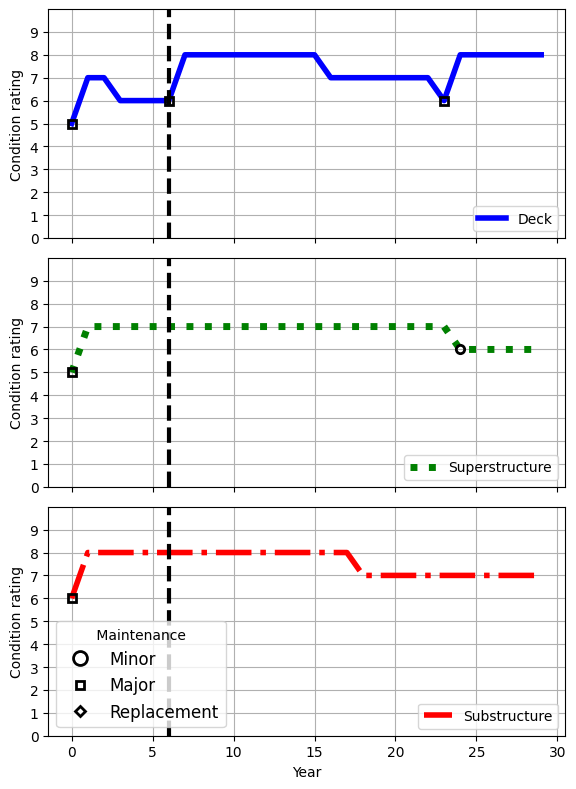

Time action:  6
AI_first tensor([42])


(-5.0, 25.0)

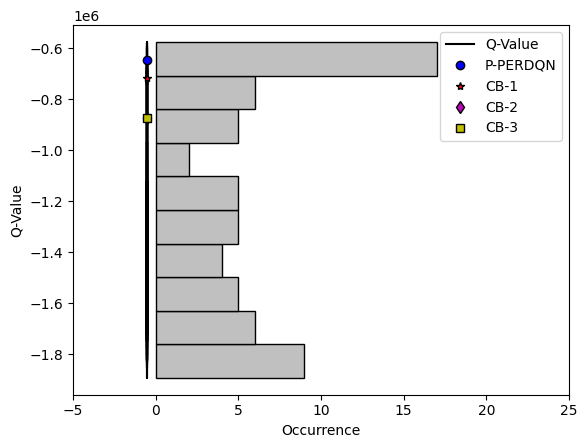

In [ ]:
"""

@author: Alireza
"""

#import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

start_time = time.time()
env = BridgeEnvFrg(life_span)
gamma = 0.96
state_shape = env.observation_space.shape
n_params = int(4)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'A_deck','L_D','ADT','r_truck'))


BATCH_SIZE = 32
GAMMA = 0.965
EPS_START = 0
EPS_END = 0
EPS_DECAY = 5000
LR = 1e-2

## Testing
# Get number of actions from gym action space
n_actions = env.action_space.n
print(type(n_actions))
# Get the number of state observations
state = env.reset()
n_observations = len(state)
print(type(len(state)))
# DQN Agent
class DQN(nn.Module):

    def __init__(self, n_inputs, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_inputs, 24)
        self.layer2 = nn.Linear(24, 24)
        self.layer3 = nn.Linear(24, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


time_jacketing=0
time_extender= 0
time_shearkey = 0

policy_net = DQN(n_observations + n_params, n_actions)
policy_net.load_state_dict(torch.load('Trained_model.pth'))

policy_net.eval()


def select_action(inputs):
    global i_episode, previous_actions_deck, previous_actions_super, previous_actions_sub, previous_state_EQ, action_vec
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * i_episode / EPS_DECAY)

    if sample == sample:
        with torch.no_grad():
            inputs_cpu = inputs.to('cpu').numpy()

            policy_type = np.random.choice(5, p=[1,0,0,0,0])  # 0: DRL, 1: Heu-Fair, 2: Heu-Good, 3: Heu-3, 4 : Do nothing


            if policy_type == 1:
                if inputs_cpu[0][0]>=4:
                    action_vec[0] = 0
                else:
                    action_vec[0] = 3

                if inputs_cpu[0][1]>=4:
                    action_vec[1] = 0
                else:
                    action_vec[0] = 3
                    action_vec[1] = 3

                if inputs_cpu[0][2]>=4:
                    action_vec[2] = 0
                else:
                    action_vec[0] = 3
                    action_vec[1] = 3
                    action_vec[2] = 3

                max_action_numpy = [np.ravel_multi_index(action_vec,(4,4,4))]
                modified_action = np.asarray(np.unravel_index(max_action_numpy, (4, 4, 4)))

            if policy_type == 2:
                if inputs_cpu[0][0]>=6:
                    action_vec[0] = 0
                elif 6 <inputs_cpu[0][0]<=4:
                    action_vec[0] = 1
                elif inputs_cpu[0][0] < 4:
                    action_vec[0] = 3


                if inputs_cpu[0][1]>=6:
                    action_vec[1] = 0
                elif 6 <inputs_cpu[0][1]<=4:
                    action_vec[1] = 1
                elif inputs_cpu[0][1] < 4:
                    action_vec[0] = 3
                    action_vec[1] = 3

                if inputs_cpu[0][2]>=6:
                    action_vec[2] = 0
                elif 6 <inputs_cpu[0][2]<=4:
                    action_vec[2] = 1
                elif inputs_cpu[0][2] < 4:
                    action_vec[0] = 3
                    action_vec[1] = 3
                    action_vec[2] = 3

                max_action_numpy = [np.ravel_multi_index(action_vec,(4,4,4))]
                modified_action = np.asarray(np.unravel_index(max_action_numpy, (4, 4, 4)))
            if policy_type == 3:
                if inputs_cpu[0][0]>=6:
                    action_vec[0] = 0
                elif inputs_cpu[0][0]==5:
                    action_vec[0] = 1
                elif inputs_cpu[0][0]==4:
                    action_vec[0] = 2
                elif inputs_cpu[0][0] < 4:
                    action_vec[0] = 3


                if inputs_cpu[0][1]>=6:
                    action_vec[1] = 0
                elif inputs_cpu[0][1]==5:
                    action_vec[1] = 1
                elif inputs_cpu[0][1]==4:
                    action_vec[1] = 2
                elif inputs_cpu[0][1] < 4:
                    action_vec[0] = 3
                    action_vec[1] = 3

                if inputs_cpu[0][2]>=6:
                    action_vec[2] = 0
                elif inputs_cpu[0][2]==5:
                    action_vec[2] = 1
                elif inputs_cpu[0][2]==4:
                    action_vec[2] = 2
                elif inputs_cpu[0][2] < 4:
                    action_vec[0] = 3
                    action_vec[1] = 3
                    action_vec[2] = 3

                max_action_numpy = [np.ravel_multi_index(action_vec,(4,4,4))]
                modified_action = np.asarray(np.unravel_index(max_action_numpy, (4, 4, 4)))

            if policy_type == 4:
                action_vec[0] = 0
                action_vec[1] = 0
                action_vec[2] = 0
                max_action_numpy = [np.ravel_multi_index(action_vec,(4,4,4))]
                modified_action = np.asarray(np.unravel_index(max_action_numpy, (4, 4, 4)))

            if policy_type == 0:
                action_values = policy_net(inputs)
                max_action = action_values.max(1)[1]  # Get the index of the maximum action

                # Convert max_action to a numpy array and then unravel it
                max_action_numpy = max_action.cpu().detach().numpy()
                modified_action = np.asarray(np.unravel_index(max_action_numpy, (4, 4, 4)))
                # here we don't let to take any action when the component is in the best condition
                if inputs_cpu[0][0] >= 6 :
                    modified_action[0] = 0

                if inputs_cpu[0][1] >= 6 :
                    modified_action[1] = 0

                if inputs_cpu[0][2] >= 6 :
                    modified_action[2] = 0


            # Constraint: Check the previous actions for each component

            if any(action != 0 for action in  previous_actions_deck) and inputs_cpu[0][0] >= 4:
                modified_action[0] = 0  # Update to "Do Nothing" if constraint is violated

            if any(action != 0 for action in previous_actions_super) and inputs_cpu[0][1] >= 4:
                modified_action[1] = 0

            if any(action != 0 for action in previous_actions_sub) and inputs_cpu[0][2] >= 4:
                modified_action[2] = 0


            # uppdate the suggested action based on the correlation of components
            if modified_action[2] == 3:
                modified_action[0] = 3
                modified_action[1] = 3

            if modified_action[1] == 3:
                modified_action[0] = 3


            previous_actions_deck.append(modified_action[0])

            previous_actions_super.append(modified_action[1])

            previous_actions_sub.append(modified_action[2])

            return torch.tensor([np.asarray(np.ravel_multi_index(modified_action, (4, 4, 4)))], device=device, dtype=torch.long), action_values


    else:
        # Exploration: Choose a random action
        random_action = env.action_space.sample()
        modified_action = np.asarray(np.unravel_index(random_action, (4, 4, 4)))
        inputs_cpu = inputs.to('cpu').numpy()

        previous_actions_deck.append(modified_action[0])

        previous_actions_super.append(modified_action[1])

        previous_actions_sub.append(modified_action[2])

        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

""" Test """

episode_test_reward = []
episode_test_C_dir = []
episode_test_C_indir = []

a=[]
d=[]
eq=[]
e=[]
di=[]
indi=[]
rw=[]

n_params = 4  # Number of bridge parameters

# Test the policy net in new episodes
year = life_span
GAMMA = 0.96
eps_test = 0.01
device = "cpu"
for i_episode in range(num_test_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward_temp = 0.0
    episode_C_dir_temp = 0.0
    episode_C_indir_temp = 0.0

    deck_area = deck_area_test
    L_d = L_d_test
    ADT = ADT_test
    r_Truck = r_Truck_test


    action_vec=[0,0,0]
    action_vec1 =[0,0,0]
    action_vec2 =[0,0,0]
    action_vec3 =[0,0,0]
    deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
    L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
    ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
    r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)

    previous_actions_deck = deque([], maxlen=5)
    previous_actions_super = deque([], maxlen=5)
    previous_actions_sub = deque([], maxlen=5)

    previous_actions_deck_CB = deque([], maxlen=5)
    previous_actions_super_CB = deque([], maxlen=5)
    previous_actions_sub_CB = deque([], maxlen=5)

    previous_state_EQ = deque([], maxlen=5)
    ttt=[]
    TT=[]
    terminated = False
    t = int(0)
    while not terminated:
        input_temp =  torch.hstack((state,deck_area,L_d,ADT,r_Truck))
        input_temp = torch.tensor(input_temp, dtype=torch.float32, device = device)
        #input_temp.clone().detach()

        state_cpu = state.to('cpu').numpy()



        action_DRL, Q_values = select_action(input_temp)



        if action_DRL >0 and t>0:
            on_t = 1
            ttt.append(t)
            if np.min(ttt) == t:
                TT = t
                on_tt = 1
                QQ=Q_values
                AI_action = action_DRL



        ### save suggested action by Heu-Fair
        if t == TT :
            if state_cpu[0][0]>=4:
                action_vec1[0] = 0
            else:
                action_vec1[0] = 3

            if state_cpu[0][1]>=4:
                action_vec1[1] = 0
            else:
                action_vec1[0] = 3
                action_vec1[1] = 3

            if state_cpu[0][2]>=4:
                action_vec1[2] = 0
            else:
                action_vec1[0] = 3
                action_vec1[1] = 3
                action_vec1[2] = 3

            # Good CB2

            if state_cpu[0][0]>=6:
                action_vec2[0] = 0
            if state_cpu[0][0]==5 or state_cpu[0][0]==4:
                action_vec2[0] = 1
            if state_cpu[0][0] < 4:
                action_vec2[0] = 3


            if state_cpu[0][1]>=6:
                action_vec2[1] = 0
            if state_cpu[0][1]==5 or state_cpu[0][1]==4:
                action_vec2[1] = 1
            if state_cpu[0][1] < 4:
                action_vec2[0] = 3
                action_vec2[1] = 3

            if state_cpu[0][2]>=6:
                action_vec2[2] = 0
            if state_cpu[0][2]==5 or state_cpu[0][2]==4:
                action_vec2[2] = 1
            if state_cpu[0][2] < 4:
                action_vec2[0] = 3
                action_vec2[1] = 3
                action_vec2[2] = 3

            # CB3

            if state_cpu[0][0]>=6:
                action_vec3[0] = 0
            if state_cpu[0][0]==5:
                action_vec3[0] = 1
            if state_cpu[0][0]==4:
                action_vec3[0] = 2
            if state_cpu[0][0] < 4:
                action_vec3[0] = 3


            if state_cpu[0][1]>=6:
                action_vec3[1] = 0
            if state_cpu[0][1]==5:
                action_vec3[1] = 1
            if state_cpu[0][1]==4:
                action_vec3[1] = 2
            if state_cpu[0][1] < 4:
                action_vec3[0] = 3
                action_vec3[1] = 3

            if state_cpu[0][2]>=6:
                action_vec3[2] = 0
            if state_cpu[0][2]==5:
                action_vec3[2] = 1
            if state_cpu[0][2]==4:
                action_vec3[2] = 2
            if state_cpu[0][2] < 4:
                action_vec3[0] = 3
                action_vec3[1] = 3
                action_vec3[2] = 3


            action_Fair = np.ravel_multi_index(action_vec1,(4,4,4))
            action_Good = np.ravel_multi_index(action_vec2,(4,4,4))
            action_3 = np.ravel_multi_index(action_vec3,(4,4,4))

        observation, C_dir, C_indir, reward, terminated, _, damage = env.step(action_DRL.item(),deck_area.item(), L_d.item(), ADT.item(), r_Truck.item() ,w1=w1)
        episode_reward_temp += reward*(GAMMA**t)
        episode_C_dir_temp += C_dir*(GAMMA**t)
        episode_C_indir_temp += C_indir*(GAMMA**t)
        a=np.ndarray.tolist(state_cpu[0])
        done = terminated
        t += 1
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0)

        # Move to the next state
        state = next_state

        d.append(a)
        eq.append(damage)
        di.append(episode_C_dir_temp)
        indi.append(episode_C_indir_temp)
        rw.append(-episode_reward_temp)
        e.append(action_DRL.item())

    episode_test_reward.append(episode_reward_temp)
    episode_test_C_dir.append(episode_C_dir_temp)
    episode_test_C_indir.append(episode_C_indir_temp)



plt.figure(1)
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import matplotlib.lines as mlines
# Data for a three-dimensional line
state_plot=np.asarray(d)
action_plot = np.unravel_index(e, (4, 4, 4))
zline_deck = state_plot[0:,0]+1
zline_super = state_plot[0:,1]+1
zline_sub = state_plot[0:,2]+1
zline_eqk = eq

xline_deck = action_plot[0]
xline_super = action_plot[1]
xline_sub = action_plot[2]

x = np.arange(0, year, 1)
y1=np.ones(year)
y2=2*(np.ones(year))
y3=3*(np.ones(year))
y4=4*(np.ones(year))



# Create a single figure with three subplots (3 rows, 1 column)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 8))

# Plot the data on each subplot
axs[0].plot(x, zline_deck, color='blue',linestyle ='-' , linewidth=4, label='Deck')
axs[0].set_ylabel('Condition rating')
axs[0].legend(loc='lower right')

axs[1].plot(x, zline_super, color='green',linestyle =':', linewidth=5, label='Superstructure')
axs[1].set_ylabel('Condition rating')
axs[1].legend(loc='lower right')

axs[2].plot(x, zline_sub, color='red',linestyle ='-.', linewidth=4, label='Substructure')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Condition rating')
legend1=axs[2].legend(loc='lower right')


xP=[]
yP=[]
xP2=[]
yP2=[]
xP3=[]
yP3=[]
for i in range(year):
    if xline_deck[i]== 1:
        xP.append(i)
        yP.append(1)
        axs[0].plot(x[i], zline_deck[i], 'k', marker = "o",markerfacecolor='none', markeredgewidth=2, label='Minor')
        plt.legend( fontsize='large', title='Maintenance marker', title_fontsize='medium')
    if xline_deck[i]== 2:
        xP.append(i)
        yP.append(2)
        axs[0].plot(x[i], zline_deck[i], 'k', marker = "s",markerfacecolor='none', markeredgewidth=2, label='Major')
        plt.legend( fontsize='large', title='Maintenance marker', title_fontsize='medium')
    if xline_deck[i]== 3:
        xP.append(i)
        yP.append(3)
        axs[0].plot(x[i], zline_deck[i], 'k', marker = "D",markerfacecolor='none', markeredgewidth=2, label='Replaement')
        plt.legend( fontsize='large', title='Maintenance marker', title_fontsize='medium')

    if xline_super[i]== 1:
        xP2.append(i)
        yP2.append(1)
        axs[1].plot(x[i], zline_super[i], 'k', marker = "o",markerfacecolor='none', markeredgewidth=2, label='Minor')
    if xline_super[i]== 2:
        xP2.append(i)
        yP2.append(2)
        axs[1].plot(x[i], zline_super[i], 'k', marker = "s",markerfacecolor='none', markeredgewidth=2, label='Major')
    if xline_super[i]== 3:
        xP2.append(i)
        yP2.append(3)
        axs[1].plot(x[i], zline_super[i], 'k', marker = "D",markerfacecolor='none', markeredgewidth=2, label='Replaement')

    if xline_sub[i]== 1:
        xP3.append(i)
        yP3.append(1)
        axs[2].plot(x[i], zline_sub[i], 'k', marker = "o",markerfacecolor='none', markeredgewidth=2, label='Minor')
    if xline_sub[i]== 2:
        xP3.append(i)
        yP3.append(2)
        axs[2].plot(x[i], zline_sub[i], 'k', marker = "s",markerfacecolor='none', markeredgewidth=2, label='Major')
    if xline_sub[i]== 3:
        xP3.append(i)
        yP3.append(3)
        axs[2].plot(x[i], zline_sub[i], 'k', marker = "D",markerfacecolor='none', markeredgewidth=2, label='Replaement')

    if zline_eqk[i] ==3:
        print('################ Extensive : ##############', i)
    if zline_eqk[i] ==4:
        print('################ Complete : ##############', i)


    if zline_eqk[i] ==1:
        print('################ slight : ##############', i)
    if zline_eqk[i] ==2:
        print('################ moderate: ##############', i)


minor_handle = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markerfacecolor='none', markeredgewidth=2, markersize=10, label='Minor')
major_handle = mlines.Line2D([], [], color='k', marker='s', linestyle='None',markerfacecolor='none', markeredgewidth=2, label='Major')
replace_handle = mlines.Line2D([], [], color='k', marker='D', linestyle='None',markerfacecolor='none', markeredgewidth=2, markersize=5, label='Replacement')

# Add the custom legend to one of the subplots (or all if needed)
legend2=axs[2].legend(handles=[minor_handle, major_handle, replace_handle], loc='lower left', fontsize='large', title=' Maintenance ', title_fontsize='medium')

axs[2].add_artist(legend1)  # Ensure the original legend is added back

 # Adjust spacing between subplots
plt.tight_layout()
axs[0].axvline(x = np.min(TT),linewidth=3, color='k', linestyle='--')
axs[1].axvline(x = np.min(TT),linewidth=3, color='k', linestyle='--')
axs[2].axvline(x = np.min(TT) ,linewidth=3, color='k', linestyle='--')

axs[0].axis(ymin=0,ymax=10)
axs[0].set_yticks(np.arange(0, 10, step=1))
axs[1].axis(ymin=0,ymax=10)
axs[1].set_yticks(np.arange(0, 10, step=1))
axs[2].axis(ymin=1,ymax=10)
axs[2].set_yticks(np.arange(0, 10, step=1))

axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.show()




###############################################################################
#######################   Transparent dicision making #########################
###############################################################################



print('Time action: ', np.min(TT))
plt.figure(2)
x_policy=1
xxx=np.ones(64)*x_policy
xxx = range(64)
AI_first= QQ.max(1)[1]
print('AI_first',AI_first)
QQ = np.asarray(QQ)


xx=np.ones(np.size(QQ))
count, bins_count = np.histogram(QQ.reshape(64), bins=8)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.ylabel('Q-Value')
plt.xlabel('Occurrence')

plt.plot( -0.5*xx,QQ[0] ,'k' )
plt.plot(-0.5,QQ[0][AI_action], 'bo',markeredgecolor='black')
plt.plot(-0.5, QQ[0][action_Fair], 'r*',markeredgecolor='black')
plt.plot(-0.5, QQ[0][action_Good], 'md',markeredgecolor='black')
plt.plot(-0.5, QQ[0][action_3], 'ys',markeredgecolor='black')
plt.legend(['Q-Value', 'P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])


plt.hist(QQ.reshape(64), bins=10, orientation='horizontal',color = "silver", edgecolor = "black")
plt.xlim([-5,25])
